# Google Trends Data Feature Extraction

First, we'll just load some packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats import zscore as zscore
from stldecompose import decompose, forecast
from scipy.stats import boxcox

%matplotlib inline

In [3]:
train = pd.read_csv('data.csv')
train.head()

Page  2014-01-12 00:00:00  2014-01-19 00:00:00  2014-01-26 00:00:00  \
0  O4L6U                   26                   34                   25   
1  ZEJWA                    0                   69                   71   
2  AYYQG                   37                   30                   28   
3  45AHC                   12                   26                   19   
4  SULFV                    0                    0                    0   

   2014-02-02 00:00:00  2014-02-09 00:00:00  2014-02-16 00:00:00  \
0                   40                   38                   33   
1                    0                   37                    0   
2                   23                   29                   26   
3                   17                   25                   21   
4                   20                    0                   22   

   2014-02-23 00:00:00  2014-03-02 00:00:00  2014-03-09 00:00:00  ...  \
0                   32                   31                   37  ...   
1                   35                   33                    0  ...   
2                   22                   23                   19  ...   
3                   22                   29                   23  ...   
4                   21                   39                    0  ...   

   2018-10-28 00:00:00  2018-11-04 00:00:00  2018-11-11 00:00:00  \
0                   25                   34                   38   
1                   29                    0                   26   
2                   42                   49                   52   
3                   30                   37                   43   
4                    0                   15                    0   

   2018-11-18 00:00:00  2018-11-25 00:00:00  2018-12-02 00:00:00  \
0                   40                   47                  100   
1                   26                   25                   26   
2                   57                   45                   40   
3                   50                   61                   59   
4                   30                    0                    0   

   2018-12-09 00:00:00  2018-12-16 00:00:00  2018-12-23 00:00:00  \
0                   59                   39                   38   
1                   26                    0                   27   
2                   38                   54                   51   
3                   65                   52                   57   
4                   15                    0                    0   

   2018-12-30 00:00:00  
0                 31.0  
1                  0.0  
2                 40.0  
3                 58.0  
4                  0.0  

[5 rows x 261 columns]

In [4]:
train.shape[0]

15175

# Time Series Visulaisation

Let us see the time series of one of these keywords. 

In [10]:
days = [r for r in range(1, train.shape[1])]

def plot_entry(idx):
    data = train.iloc[idx,1:]
    fig = plt.figure(1,figsize=(5,5))
    plt.plot(days, data)
    plt.xlabel('day')
    plt.ylabel('hits')
    plt.title(train.iloc[train.index[idx],0])
    
    plt.show()

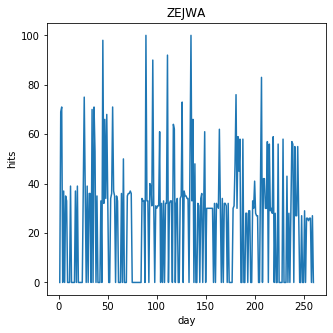

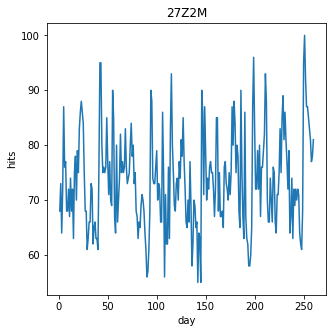

In [11]:
idx = [1, 5]
for i in idx:
    plot_entry(i)

Looks pretty noisy with no clear structure. Let's see how if we can cluster this data into groups. 

# Feature Extraction

We want to extract features from our Time Series so that we can effictively reduce its dimension and use this for clustering. 

Important features of a time series are: 

1. Trend
2. Seasonality
3. Serial Correlation
4. Non-linearity
5. Skewness
6. Kurtosis
7. Self Similarity
8. Chaos
9. Periodicity

The last 7 features are calculated on **Raw data** and the first are calculated on **Trend and Seasonality-adjusted (TSA)** data. 

### Raw Data Transformation

First let us transform our pandas dataframe in a form that can be used by statistical algorithms to calculate the above features. 

In [12]:
transformed_frame = train.copy()

In [13]:
transformed_frame = transformed_frame.set_index('Page') #Setting index to page name
transformed_frame = transformed_frame.transpose() # inverting the df so as to have dates as keys. 
transformed_frame.index = pd.to_datetime(transformed_frame.index) # setting the dtype of key datetime
transformed_frame = transformed_frame + 0.001 #Adding a small positive value to avoid undefined results

In [14]:
transformed_frame.head()

Page         O4L6U   ZEJWA   AYYQG   45AHC   SULFV   27Z2M   7P8NE   YPM9N  \
2014-01-12  26.001   0.001  37.001  12.001   0.001  68.001  21.001  55.001   
2014-01-19  34.001  69.001  30.001  26.001   0.001  73.001   0.001  48.001   
2014-01-26  25.001  71.001  28.001  19.001   0.001  64.001  11.001  65.001   
2014-02-02  40.001   0.001  23.001  17.001  20.001  72.001  21.001  75.001   
2014-02-09  38.001  37.001  29.001  25.001   0.001  87.001   0.001  78.001   

Page          V2LGY   00GNX  ...  1DXHJ  25XRV   Q1BDN   JN99W   MU6MA  \
2014-01-12  100.001  50.001  ...  0.001  0.001  44.001  60.001   0.001   
2014-01-19   91.001  56.001  ...  0.001  0.001  29.001  63.001  28.001   
2014-01-26   94.001  53.001  ...  6.001  5.001  29.001  65.001  17.001   
2014-02-02  100.001  43.001  ...  0.001  0.001  29.001  78.001  11.001   
2014-02-09  100.001  45.001  ...  0.001  0.001  20.001  63.001  17.001   

Page         Q5VOD   T8RBB   BBOBO   JPYY4   JCCCC  
2014-01-12  21.001  33.001   0.001   0.001   0.001  
2014-01-19  21.001  27.001  33.001  21.001  21.001  
2014-01-26   5.001  27.001   0.001  21.001   0.001  
2014-02-02   5.001  37.001   0.001  20.001  41.001  
2014-02-09   5.001  32.001   0.001   0.001   0.001  

[5 rows x 15175 columns]

This data is now good for calculating metrics. 

### 1. Trend and Seasonality

First we have to transform the data using a **Box-Cox Transformation**. Doing so has 3 reasons: 

1. To stabilize the variance
2. To make the seasonal effect additive, and 
3. To make the data normally distributed. 

In [15]:
boxcox_transformed_frame = transformed_frame.copy()

In [16]:
lambda_val = {}

for i in range(transformed_frame.shape[1]):
    boxcox_transformed_frame.iloc[:,i], lambda_val[i] = boxcox(transformed_frame.iloc[:,i])

In [17]:
boxcox_transformed_frame.head()

Page           O4L6U     ZEJWA     AYYQG     45AHC     SULFV     27Z2M  \
2014-01-12  3.822560 -4.823174  6.822733  2.782221 -6.392012  2.111507   
2014-01-19  4.193574  5.406031  6.174908  3.781507 -6.392012  2.125764   
2014-01-26  3.769110  5.451833  5.971166  3.367792 -6.392012  2.099019   
2014-02-02  4.423014 -4.823174  5.414482  3.223847  3.100297  2.123022   
2014-02-09  4.350214  4.442405  6.074228  3.729138 -6.392012  2.159422   

Page           7P8NE      YPM9N     V2LGY     00GNX  ...     1DXHJ     25XRV  \
2014-01-12  6.370602  17.000250  4.770102  3.657299  ... -5.123162 -6.210718   
2014-01-19 -2.175607  15.526382  4.669030  3.755999  ... -5.123162 -6.210718   
2014-01-26  4.238608  18.982794  4.703774  3.708095  ...  1.946870  1.650960   
2014-02-02  6.370602  20.847798  4.770102  3.525339  ... -5.123162 -6.210718   
2014-02-09 -2.175607  21.387762  4.770102  3.565188  ... -5.123162 -6.210718   

Page            Q1BDN     JN99W      MU6MA     Q5VOD     T8RBB      BBOBO  \
2014-01-12  13.756111  6.412848  -1.709298  9.185213  3.168705 -12.674529   
2014-01-19  10.431271  6.526322  10.053246  9.185213  3.003508   2.673868   
2014-01-26  10.431271  6.599607   7.115917  2.783754  3.003508 -12.674529   
2014-02-02  10.431271  7.036618   5.157677  2.783754  3.262045 -12.674529   
2014-02-09   8.074830  6.526322   7.115917  2.783754  3.143496 -12.674529   

Page           JPYY4     JCCCC  
2014-01-12 -2.892340 -2.619489  
2014-01-19  5.003260  5.407104  
2014-01-26  5.003260 -2.619489  
2014-02-02  4.881377  7.573214  
2014-02-09 -2.892340 -2.619489  

[5 rows x 15175 columns]

Now, let us decompose our time series. 

In [18]:
decomp = {}

for i in range(boxcox_transformed_frame.shape[1]):
    decomp[i] = decompose(boxcox_transformed_frame.iloc[:,i], period=30)

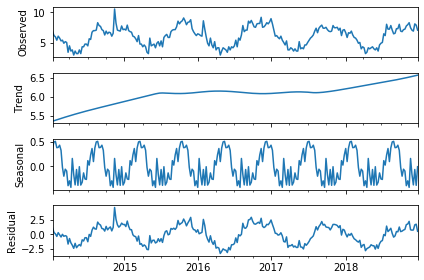

In [19]:
fig = decomp[2].plot()

The steps below are self-explanatory. 

Let us create vectors that contain the trend and seasonality. 

In [20]:
de_seasonalised_data = {}
de_trended_data = {}
tsa_data = {}
trend = {}
seasonality = {}

for i in range(boxcox_transformed_frame.shape[1]):
    de_seasonalised_data[i] = decomp[i].observed - decomp[i].seasonal 
    de_trended_data[i] = decomp[i].observed - decomp[i].trend 
    tsa_data[i] = decomp[i].observed - decomp[i].trend - decomp[i].seasonal 
    trend[i] = 1 - (np.var(tsa_data[i])/np.var(de_trended_data[i]))
    seasonality[i] = 1 - (np.var(tsa_data[i])/np.var(de_seasonalised_data[i]))

Let's save the `tsa_data` to a dataframe for future use. 

In [21]:
tsa_data_df = transformed_frame.copy()

In [22]:
for i in range(tsa_data_df.shape[1]):
    tsa_data_df.iloc[:,i] = tsa_data[i]

I want to write out this TSA data as it is used plenty of times later and I don't want to calculate it everytime. 

In [24]:
tsa_data_df.to_csv('tsa.csv', encoding='utf-8', index=False)

In [25]:
tsa_data = pd.read_csv('tsa.csv')

In [26]:
tsa_data.head()

O4L6U     ZEJWA     AYYQG     45AHC     SULFV     27Z2M     7P8NE  \
0 -0.397392 -5.674591  1.088296 -0.927956 -4.058885 -0.007457  0.724180   
1 -0.056482  5.705412  0.304142  0.285336 -3.914524  0.001187 -5.722706   
2 -0.257067  5.490700  0.076279 -0.193672 -2.801945 -0.024943 -0.241728   
3  0.447933 -5.803641 -0.361456 -0.425594  3.068828 -0.003960  1.700719   
4  0.189042  3.594174  0.280117 -0.065616 -6.242033  0.030839 -6.767948   

      YPM9N     V2LGY     00GNX  ...     1DXHJ     25XRV     Q1BDN     JN99W  \
0  0.376854  0.214086  0.082443  ...  0.941132  0.903355  3.226010  0.038749   
1 -2.174900  0.162986  0.163226  ... -0.009793  1.703996  0.650158  0.034294   
2  1.180543  0.126263  0.165132  ...  6.876178  7.008149 -0.933815  0.032806   
3  2.646599  0.214131 -0.060423  ... -0.050111  0.198036 -0.882066  0.353137   
4  2.189934  0.232876 -0.089944  ...  0.688571  0.048582 -1.252248  0.067136   

      MU6MA     Q5VOD     T8RBB     BBOBO     JPYY4     JCCCC  
0 -7.696060  0.360344  0.089040 -5.386930 -4.409168 -3.018277  
1  2.391198 -0.641059  0.048803  4.926307  3.645778  1.948595  
2 -0.286656 -6.503160 -0.025565 -1.992684  2.762470 -4.218054  
3 -1.625382 -5.418996  0.187361 -1.955237  2.861740  4.585658  
4  0.064453 -3.736685  0.079157 -5.356929 -2.515360 -3.018741  

[5 rows x 15175 columns]

Now, I want to assign these features to the pages. 

In [27]:
feature_df = train.copy()

In [28]:
feature_df.drop(feature_df.columns.difference(['Page']), 1, inplace=True)

In [29]:
feature_df['Trend'] = pd.Series(trend)
feature_df['Seasonality'] = pd.Series(seasonality)

In [30]:
feature_df.head()

Page     Trend  Seasonality
0  O4L6U  0.065781     0.379189
1  ZEJWA  0.149355     0.030360
2  AYYQG  0.037707     0.024734
3  45AHC  0.076978     0.355319
4  SULFV  0.085794     0.013775

### 2. Periodicity

# !!! Warning! Periodicity metric calculation is not complete for now. Please skip this metric. 

To determine the periodicity, we have to first detrend the time series using a regression spline with 3 knots. 

In [ ]:
from pyearth import Earth

In [ ]:
transformed_frame.head()

In [ ]:
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))

X = transformed_frame.index.values

In [ ]:
auto = {}

for i in range(transformed_frame.shape[1]):
    print(i)
    model = Earth()
    model.fit(X, transformed_frame.iloc[:,i].values)
    y_hat = model.predict(X)
    detrended = y - y_hat
    df = pd.Series(detrended)
    auto[i] = df.autocorr()

In [ ]:
feature_df['Periodicity'] = pd.Series(auto)

In [ ]:
feature_df.head()

In [ ]:
# print(model.trace())

In [ ]:
y_hat = model.predict(X)
# plt.figure()
# plt.plot(X,y,'r.')
# plt.plot(X,y_hat,'b.')
# plt.xlabel('y')
# plt.ylabel('X')
# plt.title('Simple Earth Example')
# plt.show()

In [ ]:
detrended = y-y_hat

In [ ]:
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))

In [ ]:
df = pd.Series(detrended)

In [ ]:
df.autocorr()

### 3. Serial Correlation

Serial correlation is the relationship between a variable and a lagged version of itself over various time intervals. It requires the calculation of a metric called **Box-Pierce statistic**. 

In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox

The Ljung-Box model returns 4 arrays when `boxpierce=True`. They are: Ljung-Box Statistic value, it's p-value, the Box-Pierce statistic value and it's corresponding p-value. Only the penultimate is of interest to us. We set `lag=1` to return only one value per cluster. 

First, we do the calculation for *Raw Data*. 

In [32]:
lbvalue = {}
pvalue = {}
bpvalue = {}
bppvalue = {}

for i in range(transformed_frame.shape[1]):
    lbvalue[i], pvalue[i], bpvalue[i], bppvalue[i] = acorr_ljungbox(transformed_frame.iloc[:,i].values, lags = 1, boxpierce=True) # Raw Data
    

In [33]:
feature_df['Serial Correlation (RAW)'] = pd.Series(bpvalue)

In [34]:
z = [0] * transformed_frame.shape[1]

In [35]:
for i in range(transformed_frame.shape[1]):
    z[i] = float(feature_df['Serial Correlation (RAW)'][i])

In [36]:
feature_df['Serial Correlation (RAW)'] = z

Repeating the above step for TSA data, 

In [38]:
lbvalue = {}
pvalue = {}
bpvalue = {}
bppvalue = {}

for i in range(transformed_frame.shape[1]):
    lbvalue[i], pvalue[i], bpvalue[i], bppvalue[i] = acorr_ljungbox(tsa_data.iloc[:,i].values, lags = 1, boxpierce=True) # Raw Data
    
    

In [39]:
feature_df['Serial Correlation (TSA)'] = pd.Series(bpvalue)

In [40]:
z = [0] * tsa_data.shape[1]

In [41]:
for i in range(tsa_data.shape[1]):
    z[i] = float(feature_df['Serial Correlation (TSA)'][i])

In [42]:
feature_df['Serial Correlation (TSA)'] = z

In [43]:
feature_df.head()

Page     Trend  Seasonality  Serial Correlation (RAW)  \
0  O4L6U  0.065781     0.379189                119.940700   
1  ZEJWA  0.149355     0.030360                  0.002786   
2  AYYQG  0.037707     0.024734                187.190073   
3  45AHC  0.076978     0.355319                 71.718194   
4  SULFV  0.085794     0.013775                  0.050408   

   Serial Correlation (TSA)  
0                 76.147181  
1                  0.183490  
2                207.179277  
3                 18.257196  
4                  0.435848

### 4. Non-Linearity

Because of the special characteristic (behavior) of time series data, the traditional linear models cannot handle the forecasting well compared to non-linear models. Therefore, non-linearity is an important characteristic of time series data to determine the selection of appropriate forecasting method. While the paper recommends the use of Teräesvirta’s neural network test for time series data non-linearity characteristics identification and extraction, I cannot find a Python module for it. Instead, we use the BDS score. 

In [44]:
from statsmodels.tsa.stattools import bds as bds

In [45]:
bds_score = {}
pvalue = {}

for i in range(transformed_frame.shape[1]):
    bds_score[i], pvalue[i] = bds(transformed_frame.iloc[:,i].values)

In [46]:
feature_df['Non-Linearity (RAW)'] = pd.Series(bds_score)

In [47]:
bds_score = {}
pvalue = {}

for i in range(tsa_data.shape[1]):
    bds_score[i], pvalue[i] = bds(tsa_data.iloc[:,i].values)

In [48]:
feature_df['Non-Linearity (TSA)'] = pd.Series(bds_score)

In [49]:
feature_df.head()

Page     Trend  Seasonality  Serial Correlation (RAW)  \
0  O4L6U  0.065781     0.379189                119.940700   
1  ZEJWA  0.149355     0.030360                  0.002786   
2  AYYQG  0.037707     0.024734                187.190073   
3  45AHC  0.076978     0.355319                 71.718194   
4  SULFV  0.085794     0.013775                  0.050408   

   Serial Correlation (TSA)  Non-Linearity (RAW)   Non-Linearity (TSA)  
0                 76.147181   17.820602524722577     8.681921735357644  
1                  0.183490   1.3674626221245696  -0.46647518002619387  
2                207.179277    41.81111204247334     49.33645872796761  
3                 18.257196   11.636596918301908   0.37819974939179496  
4                  0.435848  -0.7124203817370177   -1.2276346741402075

### 5. Skewness

Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or dataset, is symmetric if it looks the same to the left and to the right of the center point. It is used to characterize the degree of asymmetry of values around the mean value.

The skewness for a normal distribution is zero, and any symmetric data should have the skewness near zero. Negative values for the skewness indicate data that are skewed left, and positive values for the skewness indicate data that are skewed right. In other words, left skewness means that the left tail is heavier than the right tail. Similarly, right skewness means the right tail is heavier than the left tail.

Fortunately, `pandas` has an inbuilt function to do it. 

In [50]:
feature_df['Skewness (RAW)'] = transformed_frame.skew().values

In [51]:
feature_df['Skewness (TSA)'] = tsa_data.skew().values

In [52]:
feature_df.head()

Page     Trend  Seasonality  Serial Correlation (RAW)  \
0  O4L6U  0.065781     0.379189                119.940700   
1  ZEJWA  0.149355     0.030360                  0.002786   
2  AYYQG  0.037707     0.024734                187.190073   
3  45AHC  0.076978     0.355319                 71.718194   
4  SULFV  0.085794     0.013775                  0.050408   

   Serial Correlation (TSA)  Non-Linearity (RAW)   Non-Linearity (TSA)  \
0                 76.147181   17.820602524722577     8.681921735357644   
1                  0.183490   1.3674626221245696  -0.46647518002619387   
2                207.179277    41.81111204247334     49.33645872796761   
3                 18.257196   11.636596918301908   0.37819974939179496   
4                  0.435848  -0.7124203817370177   -1.2276346741402075   

   Skewness (RAW)  Skewness (TSA)  
0        1.185592        0.763519  
1        0.695384       -0.349157  
2        0.591947       -0.077452  
3        1.677146       -0.288070  
4        1.526156       -0.063340

### 6. Kurtosis

Kurtosis is a measure of whether the data are peaked or flat, relative to a normal distribution. A dataset with high kurtosis tends to have a distinct peak near the mean, decline rather rapidly, and have heavy tails. Datasets with low kurtosis tend to have a flat top near the mean rather than a sharp peak.

Again here, `pandas` will suffice. 

In [53]:
feature_df['Kurtosis (RAW)'] = transformed_frame.kurtosis(axis=0).values

In [54]:
feature_df['Kurtosis (TSA)'] = tsa_data.kurtosis(axis=0).values

In [55]:
feature_df.head()

Page     Trend  Seasonality  Serial Correlation (RAW)  \
0  O4L6U  0.065781     0.379189                119.940700   
1  ZEJWA  0.149355     0.030360                  0.002786   
2  AYYQG  0.037707     0.024734                187.190073   
3  45AHC  0.076978     0.355319                 71.718194   
4  SULFV  0.085794     0.013775                  0.050408   

   Serial Correlation (TSA)  Non-Linearity (RAW)   Non-Linearity (TSA)  \
0                 76.147181   17.820602524722577     8.681921735357644   
1                  0.183490   1.3674626221245696  -0.46647518002619387   
2                207.179277    41.81111204247334     49.33645872796761   
3                 18.257196   11.636596918301908   0.37819974939179496   
4                  0.435848  -0.7124203817370177   -1.2276346741402075   

   Skewness (RAW)  Skewness (TSA)  Kurtosis (RAW)  Kurtosis (TSA)  
0        1.185592        0.763519        4.569923        4.000394  
1        0.695384       -0.349157        0.120379       -1.173569  
2        0.591947       -0.077452        0.201915       -0.871658  
3        1.677146       -0.288070        5.170451        1.067465  
4        1.526156       -0.063340        2.906822       -1.619534

### 7. Self-similarity

It is a measure of the long-range dependence of the model. 

In [56]:
import nolds

In [57]:
H = {}

for i in range(transformed_frame.shape[1]):
    H[i] = nolds.hurst_rs(transformed_frame.iloc[:,i])

/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg,

/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg,

/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg,

In [58]:
feature_df['Self-Similarity'] = pd.Series(H)

In [59]:
feature_df.head()

Page     Trend  Seasonality  Serial Correlation (RAW)  \
0  O4L6U  0.065781     0.379189                119.940700   
1  ZEJWA  0.149355     0.030360                  0.002786   
2  AYYQG  0.037707     0.024734                187.190073   
3  45AHC  0.076978     0.355319                 71.718194   
4  SULFV  0.085794     0.013775                  0.050408   

   Serial Correlation (TSA)  Non-Linearity (RAW)   Non-Linearity (TSA)  \
0                 76.147181   17.820602524722577     8.681921735357644   
1                  0.183490   1.3674626221245696  -0.46647518002619387   
2                207.179277    41.81111204247334     49.33645872796761   
3                 18.257196   11.636596918301908   0.37819974939179496   
4                  0.435848  -0.7124203817370177   -1.2276346741402075   

   Skewness (RAW)  Skewness (TSA)  Kurtosis (RAW)  Kurtosis (TSA)  \
0        1.185592        0.763519        4.569923        4.000394   
1        0.695384       -0.349157        0.120379       -1.173569   
2        0.591947       -0.077452        0.201915       -0.871658   
3        1.677146       -0.288070        5.170451        1.067465   
4        1.526156       -0.063340        2.906822       -1.619534   

   Self-Similarity  
0         0.701048  
1         0.595387  
2         0.946073  
3         0.658254  
4         0.428384

### 8. Chaos

Nonlinear dynamical systems often exhibit chaos, which is characterized by sensitive dependence on initial values, or more precisely by a positive Lyapunov Exponent (LE). 

In [60]:
lyap = {}

for i in range(transformed_frame.shape[1]):
    lyap[i] = nolds.lyap_r(transformed_frame.iloc[:,i])

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/t

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/t

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/t

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarn

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefine

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarn

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/t

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/t

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), Runtime

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarn

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/t

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarn

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/t

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/t

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarn

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/t

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/t

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), Runtime

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/s

/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), Runtime

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), Runtime

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarn

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/t

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/t

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/t

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/t

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarn

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/t

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/li

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWa

/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 10
  warnings.warn(msg.format(lag), RuntimeWarning)
/opt/tljh/user/lib/python3.6/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 65
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt

In [61]:
feature_df['Chaos'] = pd.Series(lyap)

In [62]:
feature_df.head()

Page     Trend  Seasonality  Serial Correlation (RAW)  \
0  O4L6U  0.065781     0.379189                119.940700   
1  ZEJWA  0.149355     0.030360                  0.002786   
2  AYYQG  0.037707     0.024734                187.190073   
3  45AHC  0.076978     0.355319                 71.718194   
4  SULFV  0.085794     0.013775                  0.050408   

   Serial Correlation (TSA)  Non-Linearity (RAW)   Non-Linearity (TSA)  \
0                 76.147181   17.820602524722577     8.681921735357644   
1                  0.183490   1.3674626221245696  -0.46647518002619387   
2                207.179277    41.81111204247334     49.33645872796761   
3                 18.257196   11.636596918301908   0.37819974939179496   
4                  0.435848  -0.7124203817370177   -1.2276346741402075   

   Skewness (RAW)  Skewness (TSA)  Kurtosis (RAW)  Kurtosis (TSA)  \
0        1.185592        0.763519        4.569923        4.000394   
1        0.695384       -0.349157        0.120379       -1.173569   
2        0.591947       -0.077452        0.201915       -0.871658   
3        1.677146       -0.288070        5.170451        1.067465   
4        1.526156       -0.063340        2.906822       -1.619534   

   Self-Similarity     Chaos  
0         0.701048 -0.001420  
1         0.595387  0.009062  
2         0.946073 -0.002676  
3         0.658254  0.008099  
4         0.428384 -0.000749

Finally, let's save all the above calculations. 

In [ ]:
feature_df.to_csv('features.csv', encoding='utf-8', index=False)